In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(8103, 28)
(8103, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RR supports
idxs = np.where(X_relative_footsteps_acc[:, 24] == 0)[0]
X_relative_footsteps_acc_RR_support = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_RR_support = Y_relative_footsteps_acc[idxs]

## Predict RR foot -> x

In [8]:
X_relative_footsteps_acc_RR_support.shape

(4045, 28)

In [9]:
X_relative_footsteps_acc_RR_support[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0291372 ,  0.14719469,
        0.02297609,  0.00390969,  0.00879887, -0.0143033 ,  0.22920228,
        0.1869078 , -0.40553803,  0.22966338, -0.20612911, -0.40550052,
       -0.26193804,  0.13096712, -0.40069671, -0.25670755, -0.15245044,
       -0.4004477 ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        , -0.1       ])

In [10]:
Y_relative_footsteps_acc_RR_support[0, :]

array([ 0.23097709,  0.20958901,  0.22783941, -0.18877447, -0.25504919,
        0.15667753, -0.26330079, -0.12892046])

### Linear Regression

In [18]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_support[:, 6]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_support_x = LinearRegression()

# Fit the model
model_rr_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8731593017811878
RMSE:  0.008612189757504433
The lowest error is:  6.315118281641219e-06
The highest error is:  0.049391453401721935
The avg. error is:  0.0061724294835473715


In [19]:
model_rr_relative_support_x.coef_

array([[ 0.02365693,  0.10700916, -0.11851855, -0.05915781, -0.00458782,
        -0.05675388, -0.56226076, -0.60863772, -0.58661376, -0.1776179 ,
         0.09462304,  0.06642716,  0.18033662, -0.40758409]])

In [20]:
model_rr_relative_support_x.intercept_

array([0.08047134])

Text(0, 0.5, 'Predictions')

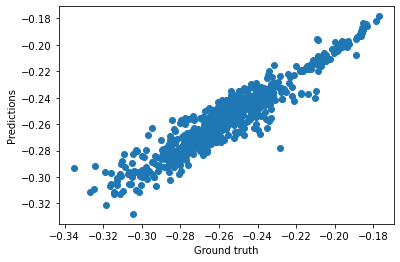

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#%store model_rr_relative_support_x

In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [24]:
# Save model
#joblib.dump(model_rr_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_support_x.sav")

### Predict FL foot -> y

In [40]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_support[:, 7]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_support_y = LinearRegression()

# Fit the model
model_rr_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.936752578418188
RMSE:  0.008829467592156744
The lowest error is:  2.653710423627942e-06
The highest error is:  0.04472750889448582
The avg. error is:  0.00585620685450001


In [41]:
model_rr_relative_support_y.coef_

array([[ 0.00603035, -0.15568447,  0.08580185, -0.01690808, -0.04716746,
        -0.01071013, -0.10946554, -0.33364832,  0.30759134, -0.31898429,
        -0.1424417 , -0.09442176,  0.31128082,  1.65676234]])

In [42]:
model_rr_relative_support_y.intercept_

array([0.12918359])

Text(0, 0.5, 'Predictions')

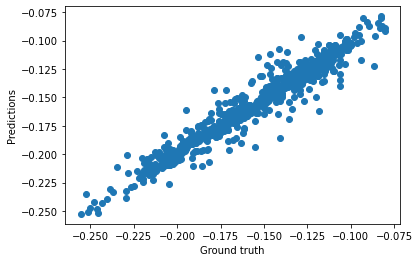

In [43]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [70]:
X_test[0].shape

(14,)

In [36]:
input_ = np.array([[0,0,0,0.1,0,0,0.23194,
    0.173315,
     0.23194,
   -0.173315,
    -0.24786,
    0.173315,
    -0.24786,
   -0.173315]])

In [37]:
input_.shape

(1, 14)

In [38]:
input_

array([[ 0.      ,  0.      ,  0.      ,  0.1     ,  0.      ,  0.      ,
         0.23194 ,  0.173315,  0.23194 , -0.173315, -0.24786 ,  0.173315,
        -0.24786 , -0.173315]])

In [39]:
model_rr_relative_support_y.predict(input_)

array([[-0.17578958]])

In [41]:
model_rr_relative_support_y.coef_.shape

(1, 14)

In [44]:
input_ @ model_rr_relative_support_y.coef_.T + model_rr_relative_support_y.intercept_

array([[-0.17578958]])

In [42]:
#%store model_rr_relative_support_y

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [44]:
# Save model
#joblib.dump(model_rr_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_support_y.sav")